# Doppler shift adjustment

Spotter buoys have a small amount of windage which causes them to have a component of drift that is due to the wind (in addition to surface currents and wave-induced motions).  A platform that is moving relative to waves experiences a Doppler shift which causes measurements made in the platform's _observed_ reference frame to deviate from the reference frame that is _intrinsic_ to the waves (Collins et al., 2017; Colosi et al., 2023; Amador et al., 2023; and references therein).  The dispersion relationship used to connect frequency domain mss to $(ak)^2$ is valid in the intrinsic reference frame, thus the observed Spotter spectra are adjusted to the intrinsic frame prior to computing mss.  This notebook adjusts the Spotter observations from the observed reference frame to the intrinsic reference frame.

In [90]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import xarray as xr

from configure import read_stored_variable
from src import buoy_accessor, kinematics, plotting, waves
from src.stats import percent_difference, percent_increase

## Setup

Read stored variables from `io.pynb` and `calculate.ipnyb`

In [91]:
%%capture
%run 'nb1-calculations.ipynb'
%run -i configure.py

In [92]:
microswift_df = read_stored_variable('microswift_df')
spotter_df = read_stored_variable('spotter_df')
ian_spotter_coamps_df = read_stored_variable('ian_spotter_coamps_df')
fiona_spotter_coamps_df = read_stored_variable('fiona_spotter_coamps_df')

plotting.configure_figures()

## Drift speed

Plot the drift speed of the Spotter and microSWIFT buoys as a function of wind speed.

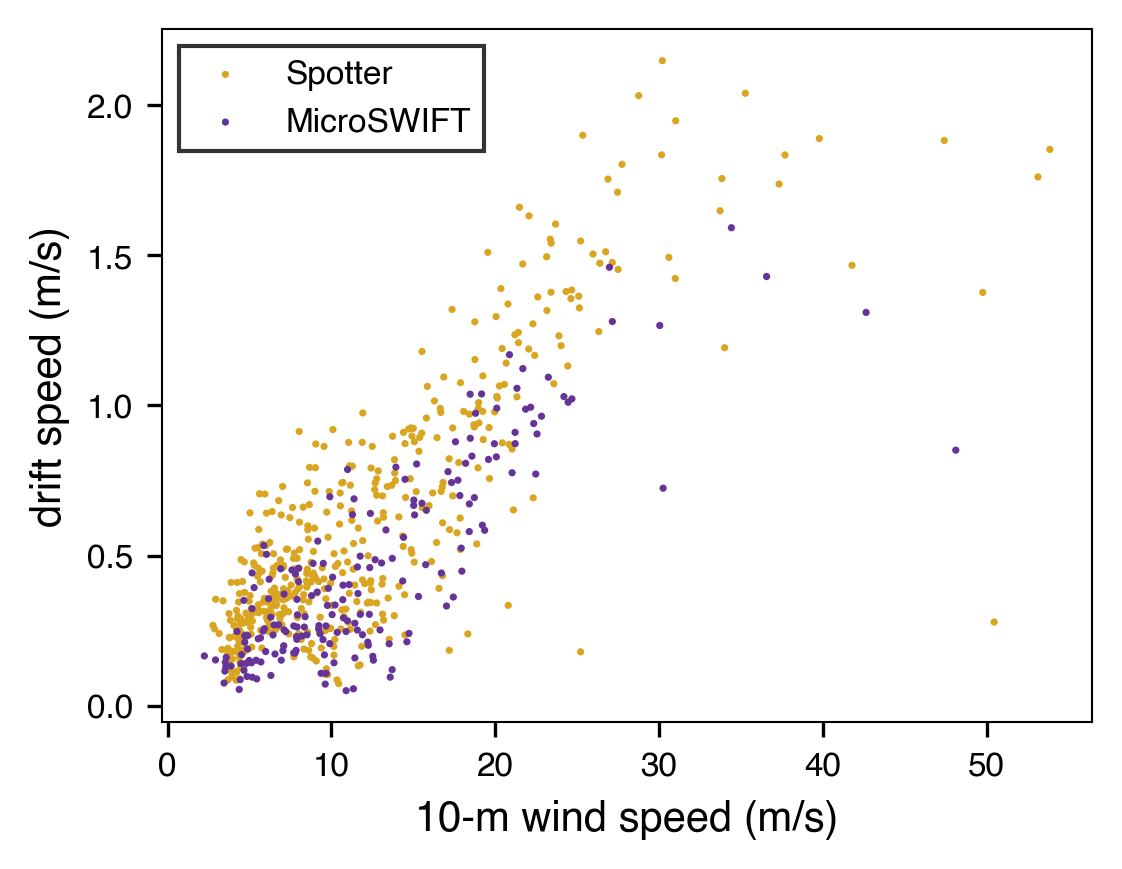

In [93]:
FIGURE_TITLE = 'drift_speed_versus_wind_speed'
FIGURE_SIZE = (4, 3)

fig,ax = plt.subplots(figsize=FIGURE_SIZE)
ax.scatter(
    x=spotter_df['wind_speed'],
    y=spotter_df['drift_speed'],
    label=plotting.get_drifter_label('spotter'),
    **plotting.spotter_scatter_kwargs,
)
ax.scatter(
    x=microswift_df['wind_speed'],
    y=microswift_df['drift_speed'],
    label=plotting.get_drifter_label('microswift'),
    **plotting.microswift_scatter_kwargs,
)

wind_speeds = np.linspace(0, 50)
ax.set_ylabel('drift speed (m/s)')
ax.set_xlabel('10-m wind speed (m/s)')
ax.legend(loc='upper left', edgecolor='k', fancybox=False)
# fig.savefig(FIGURE_TITLE + '.png')


## Stokes drift

In [ ]:
# drift_speed_east = spotter_df['drift_speed'] * np.sin(np.deg2rad(spotter_df['drift_direction']))
# drift_speed_north = spotter_df['drift_speed'] * np.cos(np.deg2rad(spotter_df['drift_direction']))

In [ ]:
# spotter_df[['stokes_drift_east', 'stokes_drift_north']]  = spotter_df.buoy.stokes_drift(
#     z_elevation=0,
#     energy_density_col='energy_density',
#     frequency_col='frequency',
#     wavenumber_col='wavenumber',
# )
# spotter_df['stokes_drift_magnitude'] = np.sqrt(spotter_df['stokes_drift_east']**2 + spotter_df['stokes_drift_north']**2)

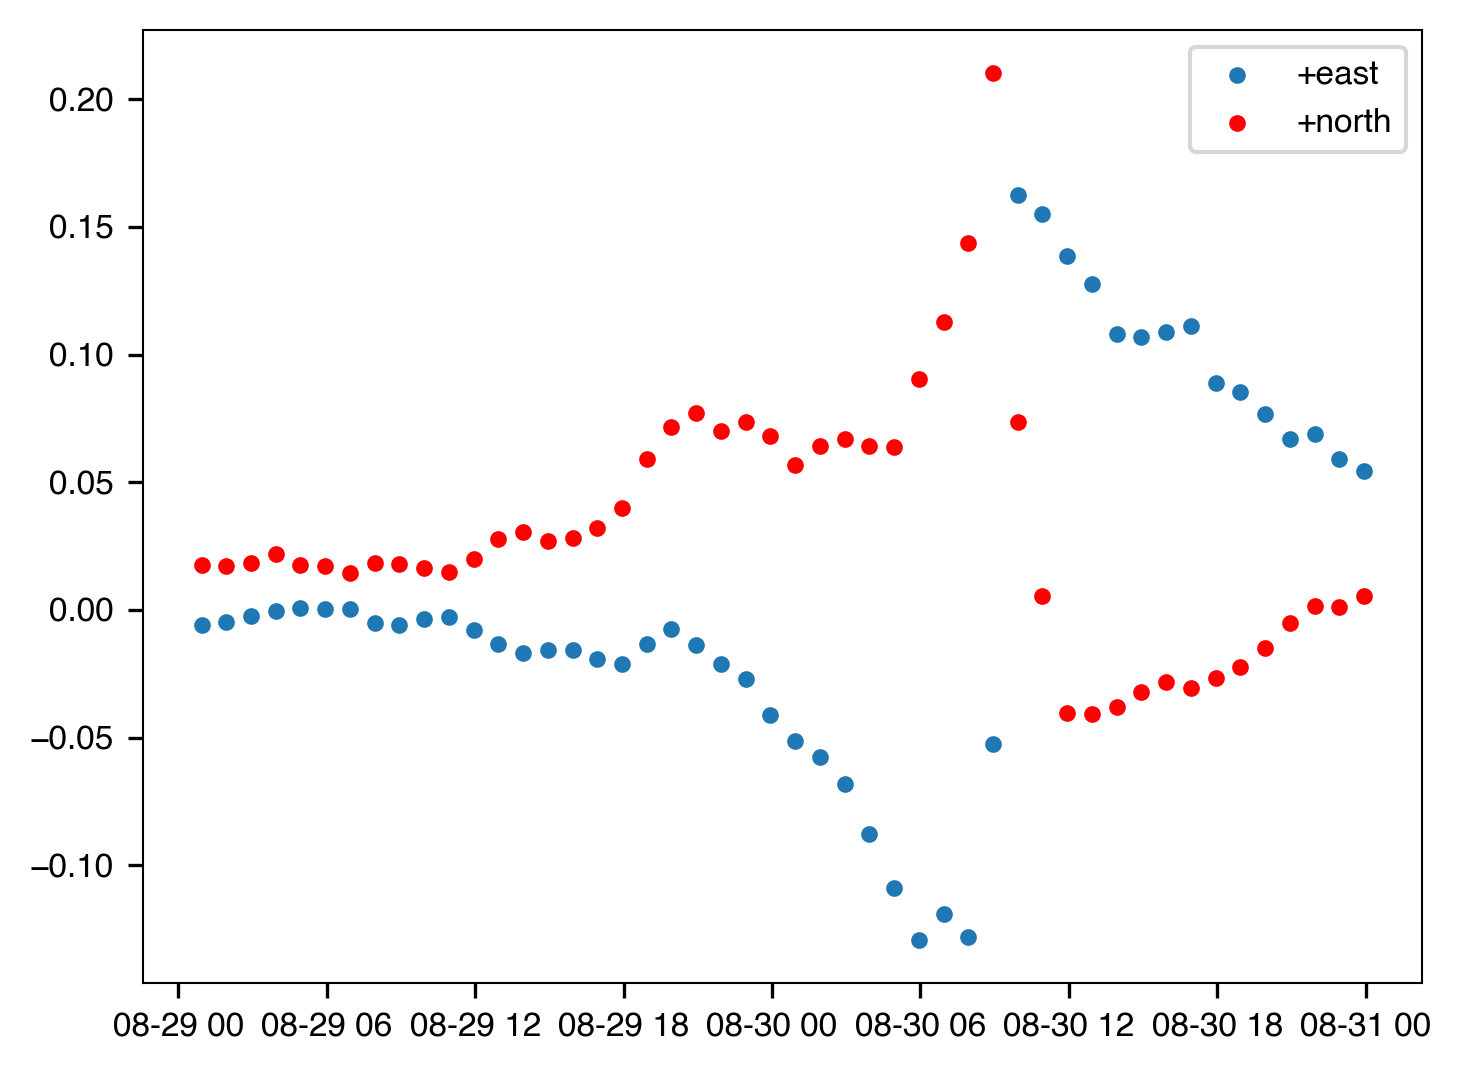

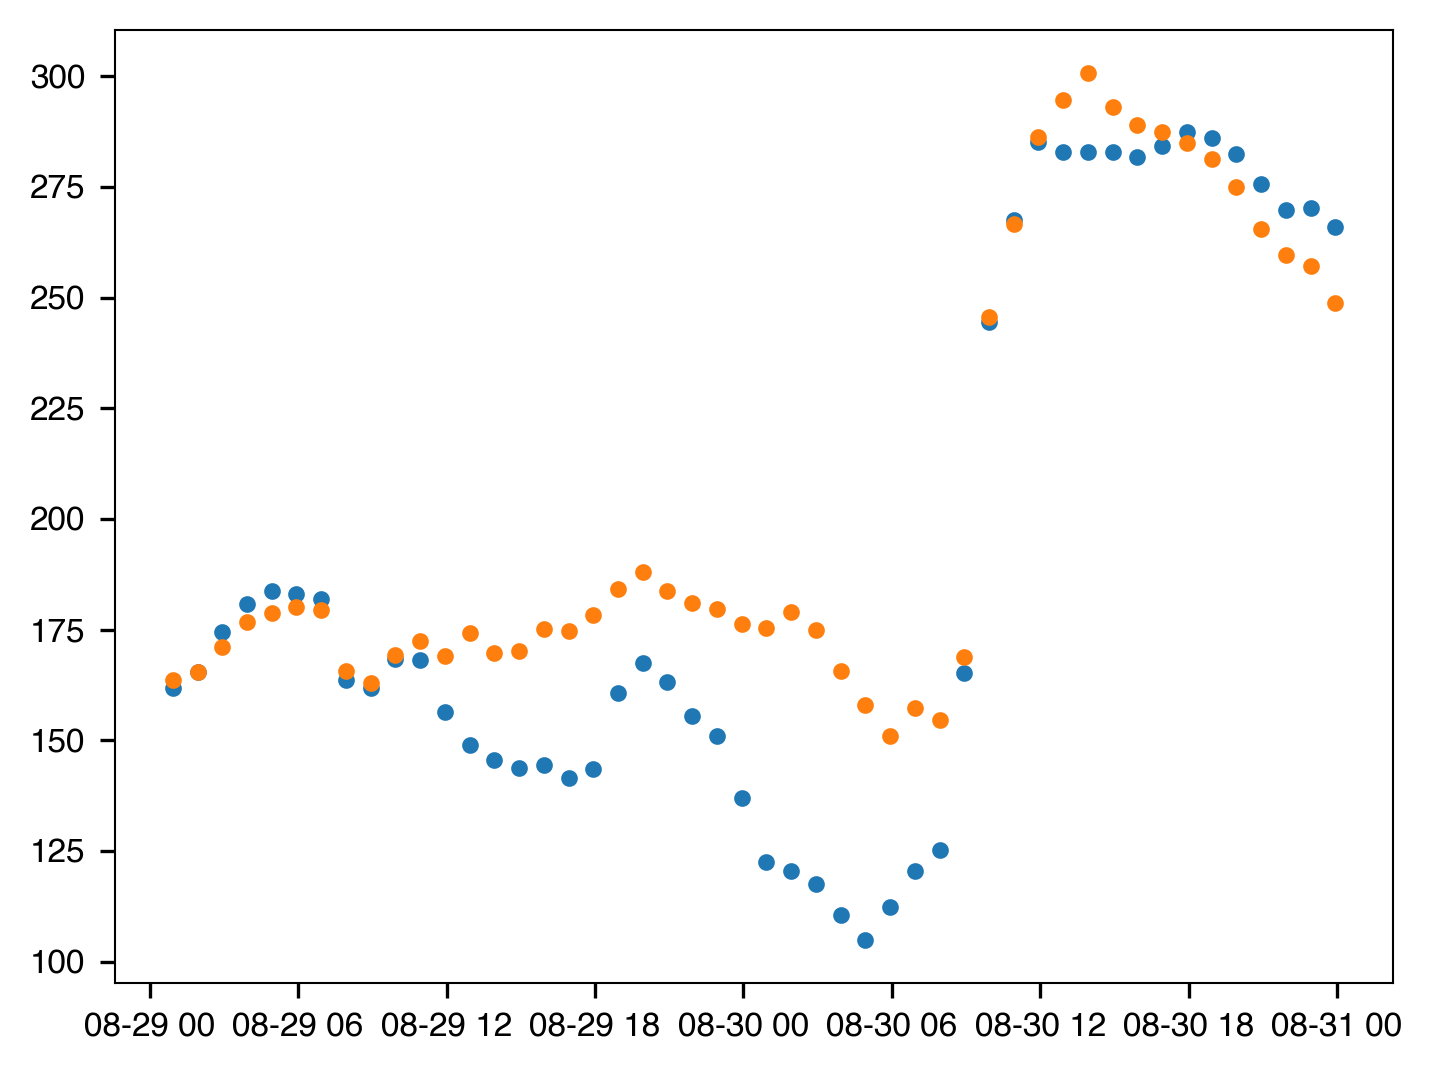

In [94]:
fig, ax = plt.subplots()
ax.scatter(
    spotter_df.loc['SPOT-30103D'].index.get_level_values('time'),
    spotter_df.loc['SPOT-30103D']['stokes_drift_east'],
    label='+east'
)
ax.scatter(
    spotter_df.loc['SPOT-30103D'].index.get_level_values('time'),
    spotter_df.loc['SPOT-30103D']['stokes_drift_north'],
    color='r',
    label='+north'
)
ax.legend()

fig, ax = plt.subplots()
ax.scatter(
    spotter_df.loc['SPOT-30103D'].index.get_level_values('time'),
    spotter_df.loc['SPOT-30103D']['mss_weighted_direction'],
)
ax.scatter(
    spotter_df.loc['SPOT-30103D'].index.get_level_values('time'),
    spotter_df.loc['SPOT-30103D']['mean_direction'],
)

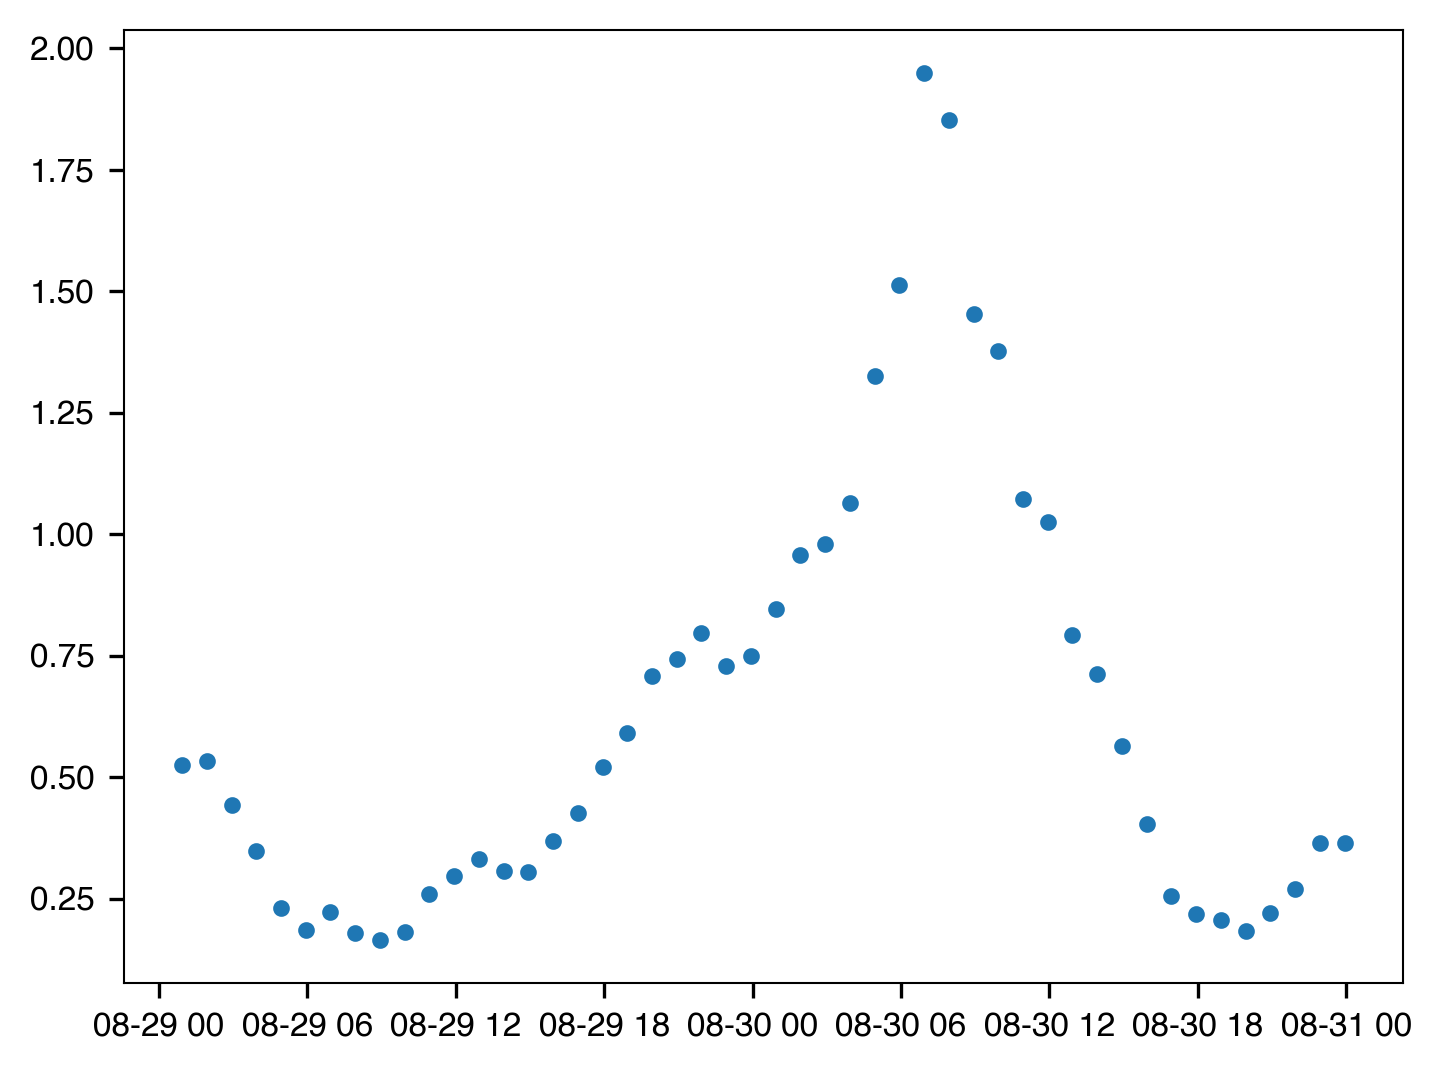

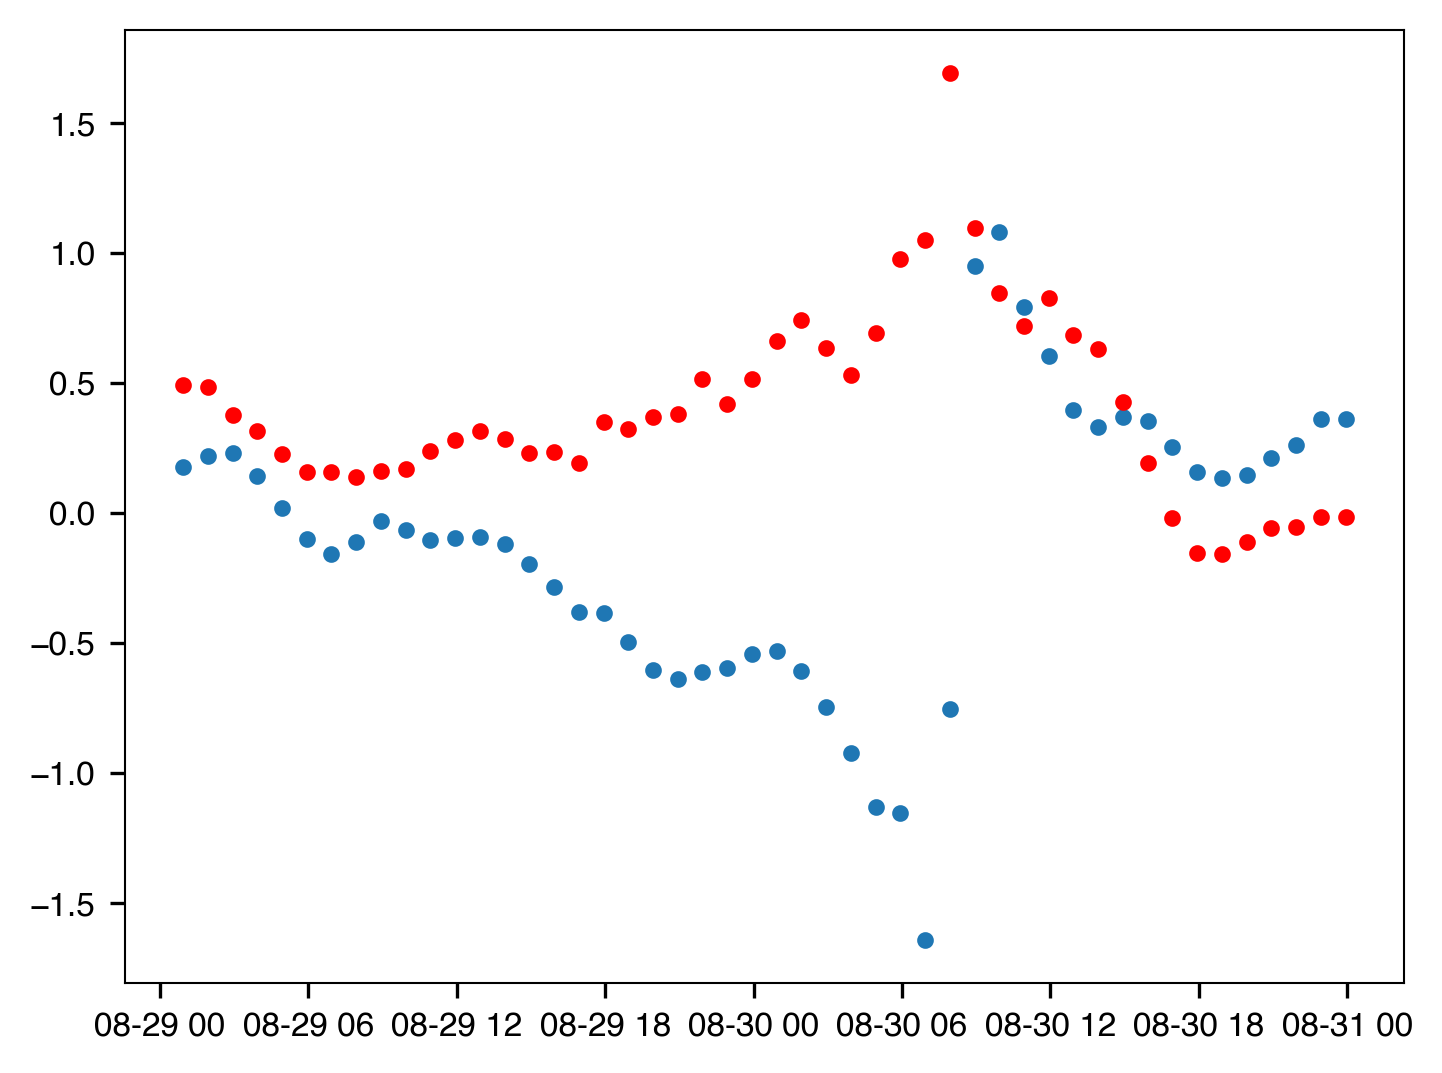

In [291]:
fig, ax = plt.subplots()
ax.scatter(
    spotter_df.loc['SPOT-30103D'].index.get_level_values('time'),
    spotter_df.loc['SPOT-30103D']['drift_speed'],
)

fig, ax = plt.subplots()
ax.scatter(
    spotter_df.loc['SPOT-30103D'].index.get_level_values('time'),
    drift_speed_east.loc['SPOT-30103D'],
)
ax.scatter(
    spotter_df.loc['SPOT-30103D'].index.get_level_values('time'),
    drift_speed_north.loc['SPOT-30103D'],
    color='r',
)

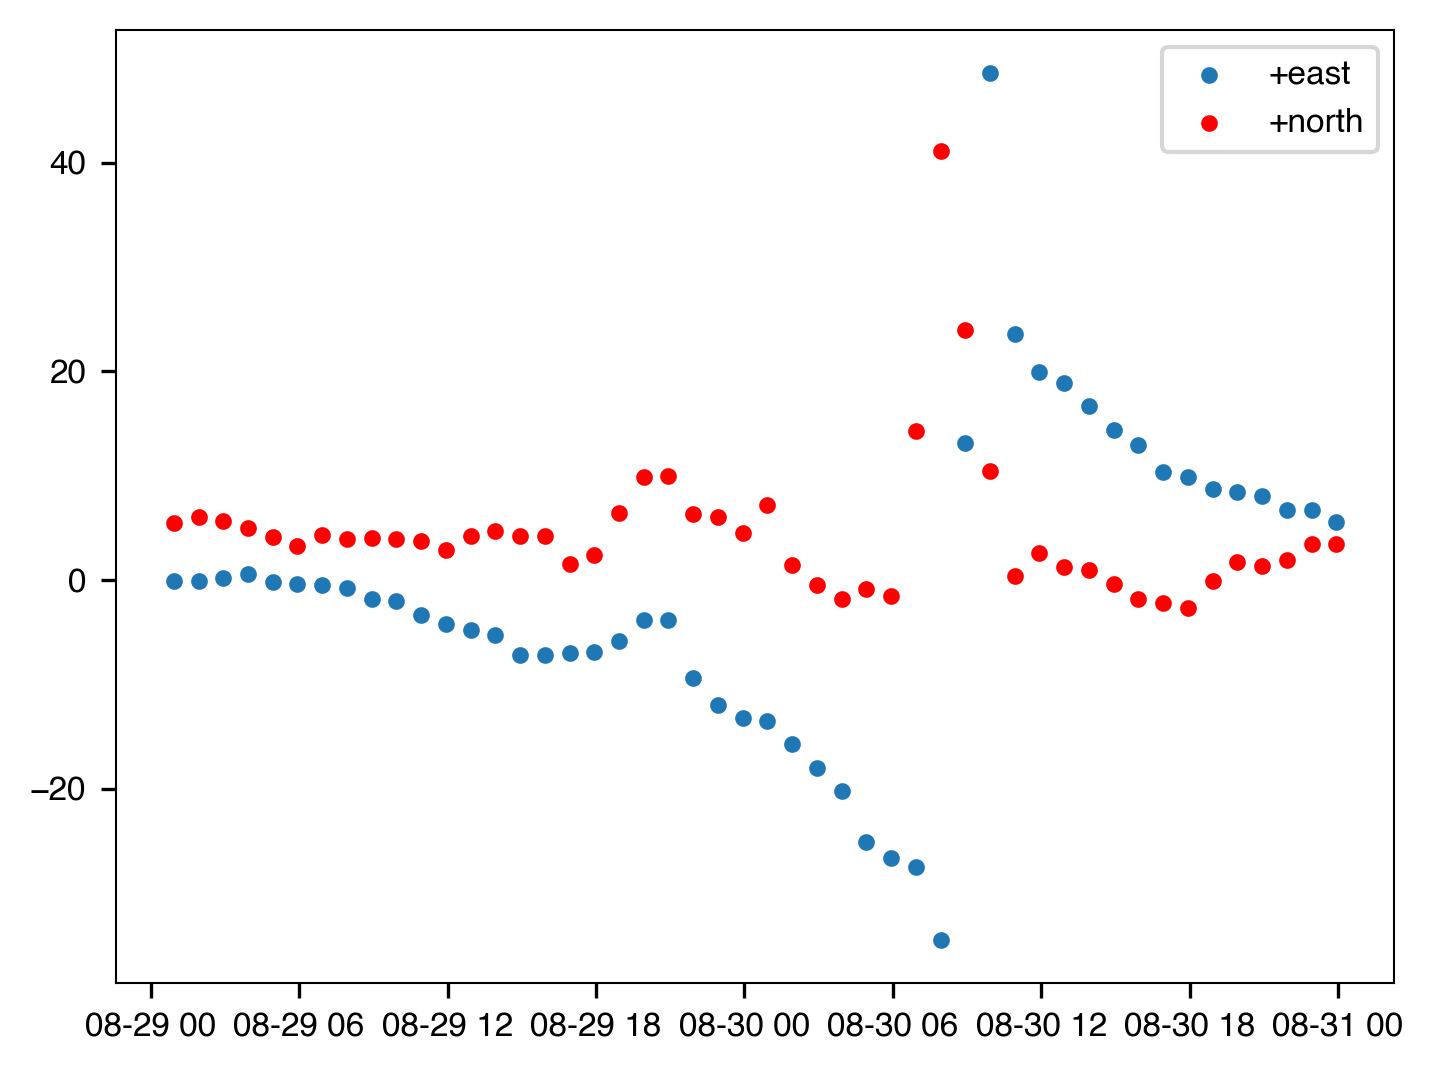

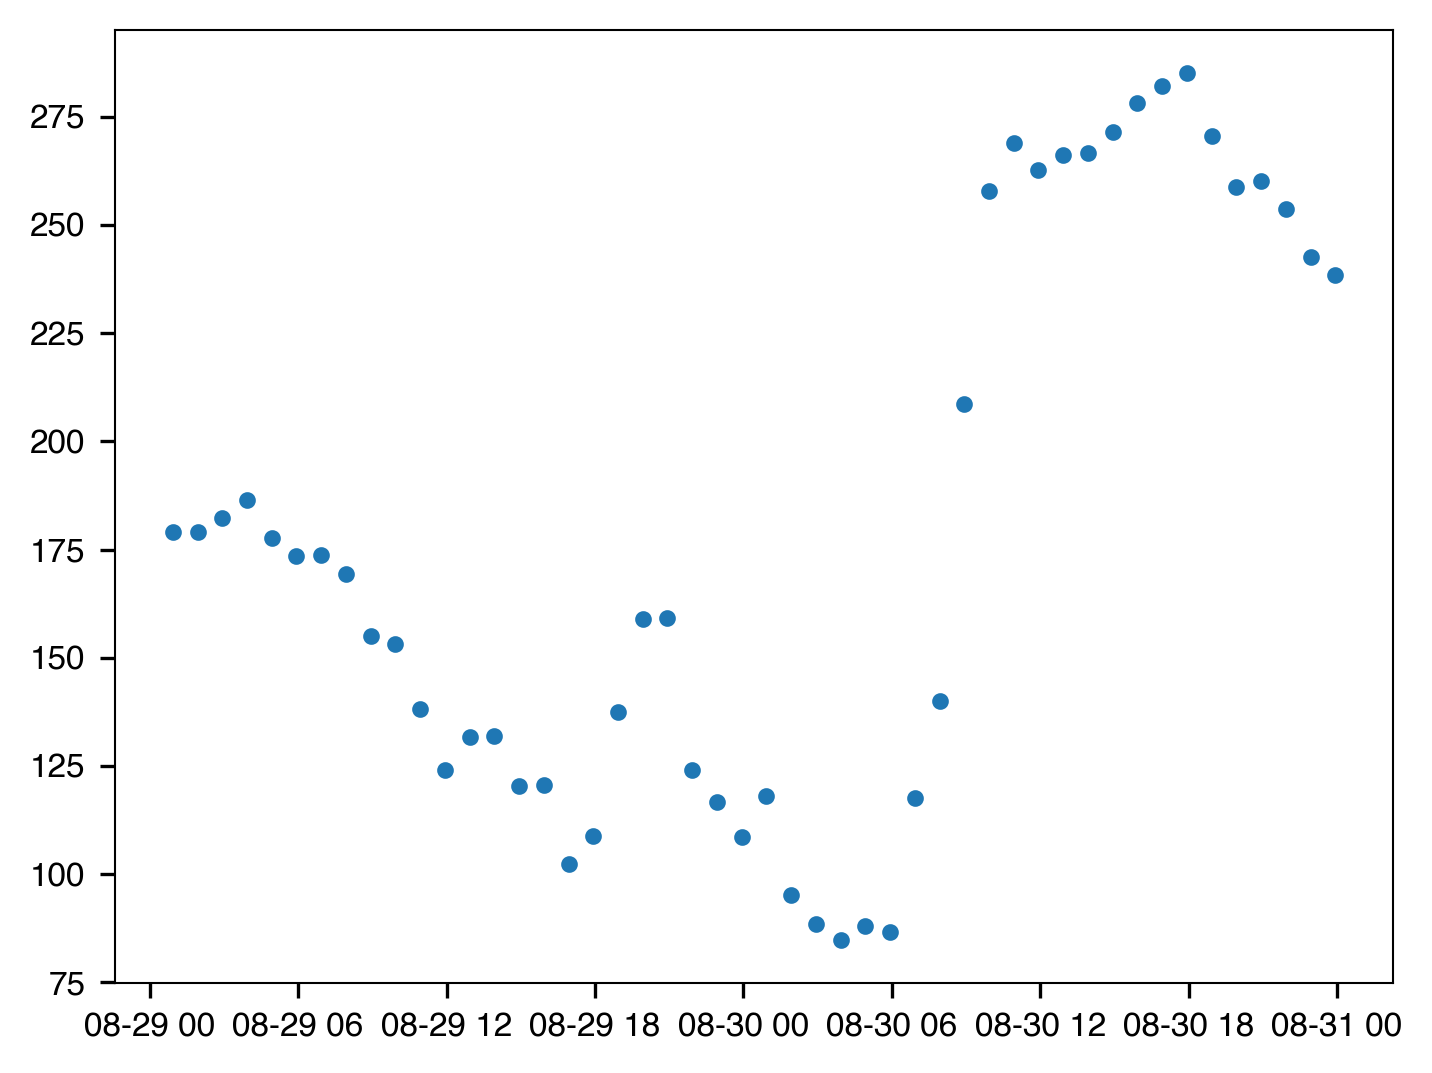

In [12]:
fig, ax = plt.subplots()
ax.scatter(
    spotter_df.loc['SPOT-30103D'].index.get_level_values('time'),
    spotter_df.loc['SPOT-30103D']['wind_speed_u'],
    label='+east'
)
ax.scatter(
    spotter_df.loc['SPOT-30103D'].index.get_level_values('time'),
    spotter_df.loc['SPOT-30103D']['wind_speed_v'],
    color='r',
    label='+north'
)
ax.legend()

fig, ax = plt.subplots()
ax.scatter(
    spotter_df.loc['SPOT-30103D'].index.get_level_values('time'),
    spotter_df.loc['SPOT-30103D']['wind_direction'],
)

The Spotter buoys drift faster than microSWIFTs across all wind speeds.  This is due the windage of the Spotter hull, which has a larger amount of freeboard compared to the low-profile microSWIFTs.

The windage can be estimated by calculating the ratio of drift speed to wind speed.

In [15]:
def drift_to_wind_speed_ratio(drifter_df):
    return drifter_df['drift_speed'] / drifter_df['wind_speed']

In [16]:
microswift_df['drift_to_wind_ratio'] = drift_to_wind_speed_ratio(microswift_df)
spotter_df['drift_to_wind_ratio'] = drift_to_wind_speed_ratio(spotter_df)

Fit a polynomial to compare the drift speed to wind speed ratio across buoys.

In [17]:
# Fit to a subset of the data without NaNs.
spotter_subset_df = (spotter_df
                     .dropna(subset=['wind_speed', 'drift_speed'])
                     .sort_values(by='wind_speed'))
microswift_subset_df = (microswift_df
                        .dropna(subset=['wind_speed', 'drift_speed'])
                        .sort_values(by='wind_speed'))

spotter_drift_to_wind_ratio_poly_fit = np.polynomial.Polynomial.fit(
    x=spotter_subset_df['wind_speed'],
    y=spotter_subset_df['drift_to_wind_ratio'],
    deg=4,
)

microswift_drift_to_wind_ratio_poly_fit = np.polynomial.Polynomial.fit(
    x=microswift_subset_df['wind_speed'],
    y=microswift_subset_df['drift_to_wind_ratio'],
    deg=4,
)

# Define a wind speed array for plotting.
wind_speeds = np.linspace(5, 50)

Plot the ratio of drift speed to wind speed as a function of wind speed.

Text(0.02, 0.5, 'drift speed to wind speed ratio (%)')

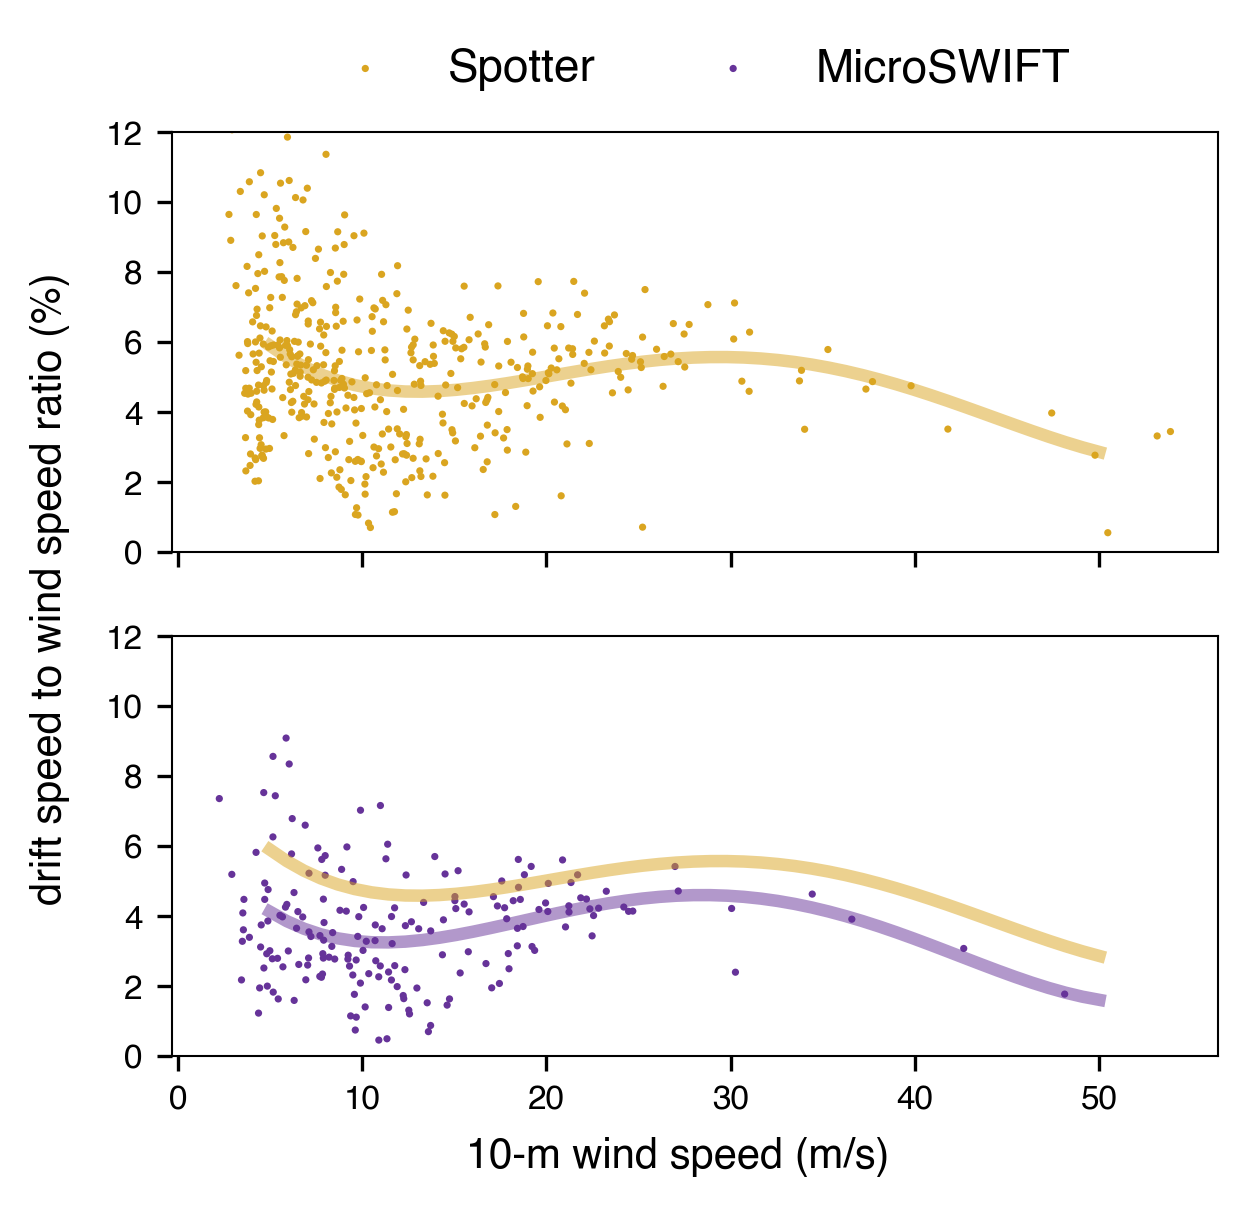

In [18]:
FIGURE_TITLE = 'drift_speed_ratio_versus_wind_speed'
FIGURE_SIZE = (4.5, 4)

fig,ax = plt.subplots(2, 1, figsize=FIGURE_SIZE, sharex=True, sharey=True)
spotter_markers = ax[0].scatter(
    x=spotter_df['wind_speed'],
    y=spotter_df['drift_to_wind_ratio'] * 100,
    label=plotting.get_drifter_label('spotter'),
    **plotting.spotter_scatter_kwargs,
)
ax[0].plot(
    wind_speeds,
    spotter_drift_to_wind_ratio_poly_fit(wind_speeds) * 100,
    color=plotting.get_drifter_color('spotter'),
    linestyle='-',
    linewidth=3,
    alpha=0.5,
)

microswift_markers = ax[1].scatter(
    x=microswift_df['wind_speed'],
    y=microswift_df['drift_to_wind_ratio'] * 100,
    label=plotting.get_drifter_label('microswift'),
    **plotting.microswift_scatter_kwargs,
)
ax[1].plot(
    wind_speeds,
    microswift_drift_to_wind_ratio_poly_fit(wind_speeds) * 100,
    color=plotting.get_drifter_color('microswift'),
    linestyle='-',
    linewidth=3,
    alpha=0.5,
)

# Re-plot the Spotter fit on the microSWIFT axes.
ax[1].plot(
    wind_speeds,
    spotter_drift_to_wind_ratio_poly_fit(wind_speeds) * 100,
    color=plotting.get_drifter_color('spotter'),
    linestyle='-',
    linewidth=3,
    alpha=0.5,
)

ax[0].legend(
    handles=[spotter_markers, microswift_markers],
    loc='center',
    edgecolor='none',
    ncols=3,
    bbox_to_anchor=(0.5, 1.15),
    fontsize=11,
    frameon=False,
)

ax[0].set_ylim([0, 0.12 * 100])
fig.supxlabel('10-m wind speed (m/s)', fontsize=plotting.normal_font_size)
fig.supylabel('drift speed to wind speed ratio (%)', fontsize=plotting.normal_font_size)


The ratio of drift speed to wind speed with wind speed for both Spotter and microSWIFT.  The Spotter ratio is consistently higher, however the difference is nearly constant across all wind speeds.

Spotter drift speed, $U$, relative to the waves due to windage (i.e., wind slip) is estimated by comparing to microSWIFT buoys within the dataset.  
The microSWIFTs have minimal wind slip due to their low freeboard, thus any drift is assumed to be due to surface currents.

In [89]:
spotter_drift_ratio = spotter_drift_to_wind_ratio_poly_fit(wind_speeds)
microswift_drift_ratio = microswift_drift_to_wind_ratio_poly_fit(wind_speeds)
wind_slip_rel_micros = spotter_drift_ratio - microswift_drift_ratio
mean_wind_slip = wind_slip_rel_micros.mean()
print(f'Mean Spotter ratio: {100 * spotter_drift_ratio.mean():.2f}%')
print(f'Mean MicroSWIFT ratio: {100 * microswift_drift_ratio.mean():.2f}%')
print(f'Mean Spotter wind slip (Spotter - microSWIFT): {100 * mean_wind_slip:.1f}%')

spotter_df['drift_speed_wind'] = mean_wind_slip * spotter_df['wind_speed']
spotter_df['drift_speed_east_wind'] = mean_wind_slip * spotter_df['wind_speed_u']
spotter_df['drift_speed_north_wind'] = mean_wind_slip * spotter_df['wind_speed_v']


Mean Spotter ratio: 4.80%
Mean MicroSWIFT ratio: 3.59%
Mean Spotter wind slip (Spotter - microSWIFT): 1.2%


In [ ]:
# TODO: update

Across all wind speeds in the dataset, the microSWIFTs have a mean drift-to-wind-speed ratio of 3.5%, which is close to the rule of thumb for ocean surface drift speed as 3% of the 10-m wind speed.  The mean drift-to-wind-speed ratio of the Spotters is 4.7%, which suggests the 1.2% difference is due to wind slip ($U$ = 1.2% of $U_{10}$).  This is close to the 1% wind slip estimated for the Spotter in (Houghton, 2021) and the 1.09% mean wind slip for the similarly-sized SWIFT v4 (Iyer, 2022).

### Spotter wind slip adjustment

Remove the Spotter wind drift and refit.

In [87]:
spotter_df['drift_speed_adjusted'] = spotter_df['drift_speed'] - spotter_df['drift_speed_wind']
spotter_df['drift_to_wind_ratio_adjusted'] = spotter_df['drift_speed_adjusted'] / spotter_df['wind_speed']

spotter_subset_df = spotter_df.dropna(subset=['wind_speed', 'drift_speed']).sort_values(by='wind_speed') #.query('20 <= coamps_ws <= 30')

spotter_drift_to_wind_ratio_adjusted_poly_fit = np.polynomial.Polynomial.fit(
    x=spotter_subset_df['wind_speed'],
    y=spotter_subset_df['drift_to_wind_ratio_adjusted'],
    deg=4,
)

Plot the ratios for each buoy on separate panels.  Add the fit to the adjusted Spotter ratio (wind slip removed) as a dashed line on the microSWIFT plot.

Text(0.02, 0.5, 'drift speed to wind speed ratio (%)')

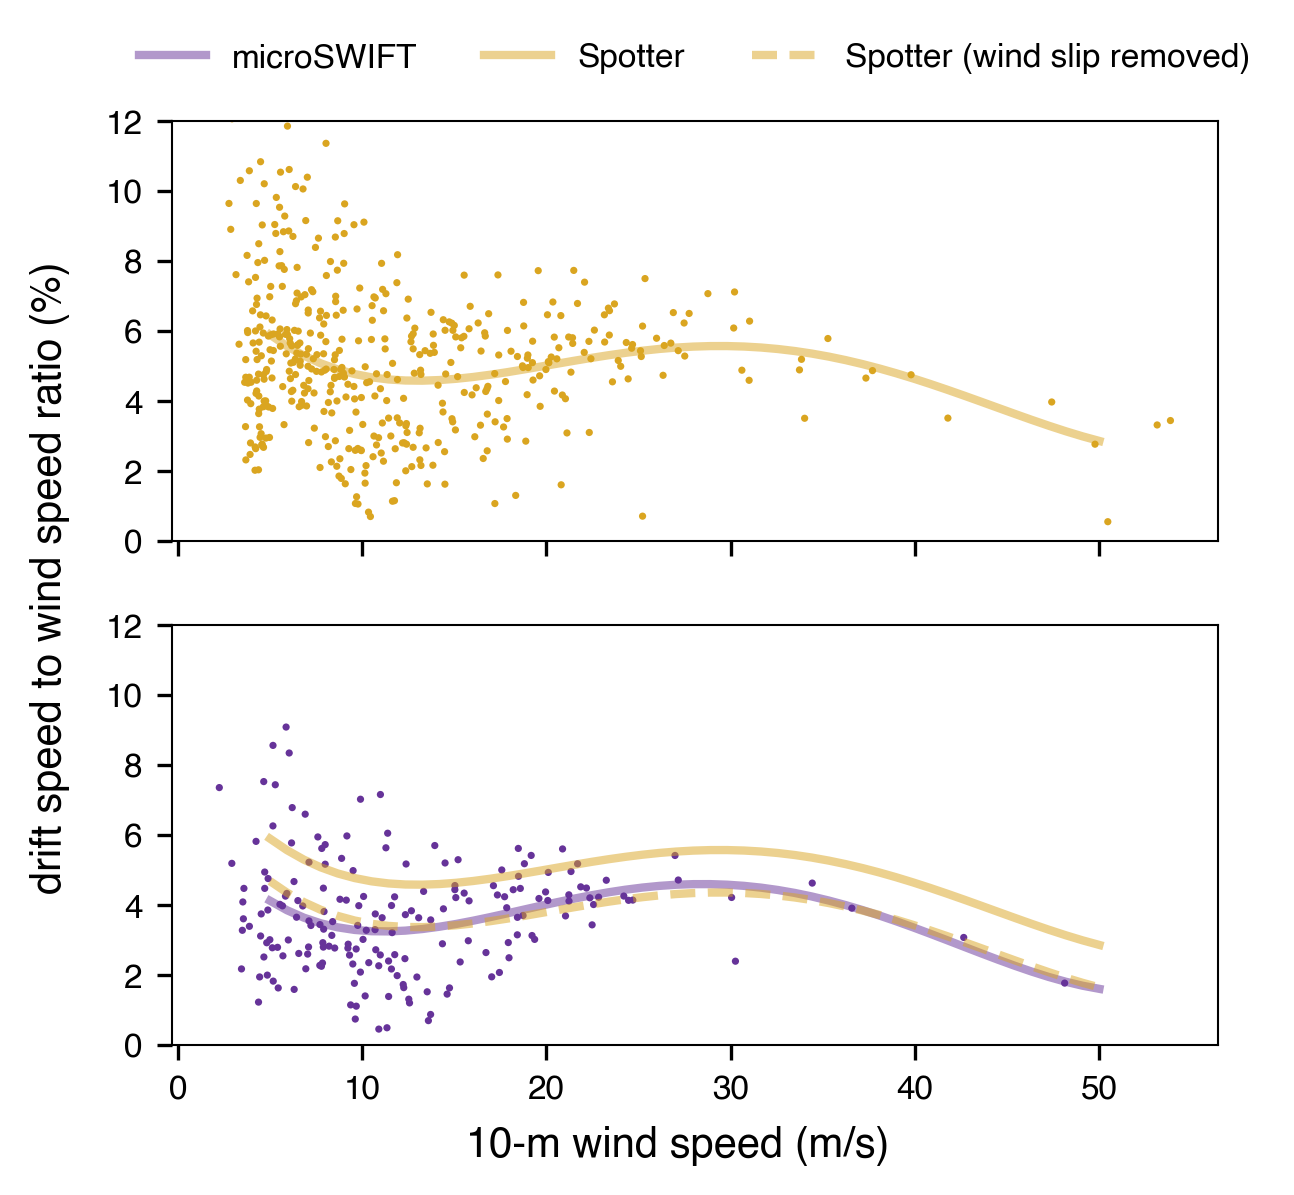

In [11]:
FIGURE_TITLE = 'afig-drift_speed_ratio_versus_wind_speed'
FIGURE_SIZE = (4.5, 4)


fig,ax = plt.subplots(2, 1, figsize=FIGURE_SIZE, sharex=True, sharey=True)
spotter_markers = ax[0].scatter(
    x=spotter_df['wind_speed'],
    y=spotter_df['drift_to_wind_ratio'] * 100,
    label=plotting.get_drifter_label('spotter'),
    **plotting.spotter_scatter_kwargs,
)
ax[0].plot(
    wind_speeds,
    spotter_drift_to_wind_ratio_poly_fit(wind_speeds) * 100,
    color=plotting.get_drifter_color('spotter'),
    linestyle='-',
    linewidth=2,
    alpha=0.5,
)

microswift_markers = ax[1].scatter(
    x=microswift_df['wind_speed'],
    y=microswift_df['drift_to_wind_ratio'] * 100,
    label=plotting.get_drifter_label('microswift'),
    **plotting.microswift_scatter_kwargs,
)
microswift_line = ax[1].plot(
    wind_speeds,
    microswift_drift_to_wind_ratio_poly_fit(wind_speeds) * 100,
    color=plotting.get_drifter_color('microswift'),
    linestyle='-',
    linewidth=2,
    alpha=0.5,
    label='microSWIFT',
)
spotter_line = ax[1].plot(
    wind_speeds,
    spotter_drift_to_wind_ratio_poly_fit(wind_speeds) * 100,
    color=plotting.get_drifter_color('spotter'),
    linestyle='-',
    linewidth=2,
    alpha=0.5,
    label='Spotter',
)
spotter_adjusted_line = ax[1].plot(
    wind_speeds,
    spotter_drift_to_wind_ratio_adjusted_poly_fit(wind_speeds) * 100,
    color=plotting.get_drifter_color('spotter'),
    linestyle='--',
    dashes=(3, 1.5),
    linewidth=2,
    alpha=0.5,
    label='Spotter (wind slip removed)',
)

ax[0].legend(
    handles=microswift_line + spotter_line + spotter_adjusted_line,
    loc='center',
    edgecolor='none',
    ncols=3,
    bbox_to_anchor=(0.5, 1.15),
    frameon=False,
    fontsize=plotting.small_font_size,
)

ax[0].set_ylim([0, 0.12 * 100])
fig.supxlabel('10-m wind speed (m/s)', fontsize=plotting.normal_font_size)
fig.supylabel('drift speed to wind speed ratio (%)', fontsize=plotting.normal_font_size)

# fig.savefig(FIGURE_TITLE + '.png')


With the slip removed, the Spotter drift speed to wind speed ratio matches the microSWIFT across all wind speeds.

## Doppler shift adjustment

For spectral wave measurements made in time, the Doppler shift manifests as a modulation in frequency.
Frequencies in the observed reference frame are mapped to frequencies in the intrinsic reference frame as

\begin{equation*}
    f_\mathrm{in} = f_\mathrm{ob} + \frac{U k \cos(\theta_r)}{2 \pi}
\end{equation*}

where $f_\mathrm{in}$ is frequency in the intrinsic reference frame, $f_\mathrm{ob}$ is frequency in the observed reference frame, $k$ is the magnitude of the wavenumber vector (which is invariant between reference frames), $U$ is the platform's speed, and $\theta_r$ is the relative heading of the platform with respect to the waves.
After mapping the frequencies, the Jacobian, $df_\mathrm{ob}/df_\mathrm{in}$, is used to map the observed energy spectrum to the intrinsic reference frame

\begin{equation*}
    E_\mathrm{in}(f_\mathrm{in}) = E_\mathrm{ob}(f_\mathrm{ob}) \frac{d f_\mathrm{ob}}{d f_\mathrm{in}}
\end{equation*}

where $E_\mathrm{in}$ and $E_\mathrm{ob}$ are the intrinsic and observed elevation variance spectra, respectively.
The Jacobian is required to conserve variance and can be estimated using finite differencing (Collins et al., 2017).
Following previous Doppler adjustment procedures, the deep water linear dispersion relationship, $f_\mathrm{in} = \sqrt{gk} / (2\pi)$, is used to obtain a quadratic equation in $k$.
The observed frequencies are then mapped to intrinsic frequencies considering ambiguities and limits discussed in Collins et al. (2017) and Colosi et al. (2023).

The Doppler shift experienced in the observed reference frame is typically largest at high frequencies (high $k$).
While the effect on low-order moments (e.g., significant wave height) can be minimal, differences in high-order moments between observed and intrinsic reference frames can be large.

The relative heading of the platform with respect to waves, $\theta_r$, is determined using a wave direction estimated from the Spotter's directional moments and its drift direction

\begin{equation*}
    \theta_r(f) = \theta_\mathrm{wave}(f) - \theta_\mathrm{drift}
\end{equation*}

here $\theta_\mathrm{wave}$ is 
a smoothed, frequency-dependent wave direction calculated from energy-weighted directional moments, $a_1(f)$ and $b_1(f)$, in sliding windows of 7 frequency bands.  Drift direction, $\theta_\mathrm{drift}$, is estimated from hourly GPS fixes.  Both $\theta_\mathrm{wave}$ and $\theta_\mathrm{drift}$ are in the ``going to'' convention.

(See the associated functions in `src/`)


In [30]:
spotter_df['drift_speed_east_relative_to_surface'] = spotter_df['drift_speed_east_wind'] + spotter_df['stokes_drift_east']
spotter_df['drift_speed_north_relative_to_surface'] = spotter_df['drift_speed_north_wind'] + spotter_df['stokes_drift_north']
spotter_df['drift_speed_relative_to_surface'] = np.sqrt(spotter_df['drift_speed_east_relative_to_surface']**2 + spotter_df['drift_speed_north_relative_to_surface']**2)


In [63]:
def components_to_direction(u_component, v_component):
    direction_from_north_going_to = np.arctan2(u_component, v_component)
    return np.mod(np.rad2deg(direction_from_north_going_to), 360)

    # return np.rad2deg(np.arctan2(u_component, v_component))

In [64]:
spotter_df['drift_direction_relative_to_surface'] = components_to_direction(
    spotter_df['drift_speed_east_relative_to_surface'],
    spotter_df['drift_speed_north_relative_to_surface'],
)


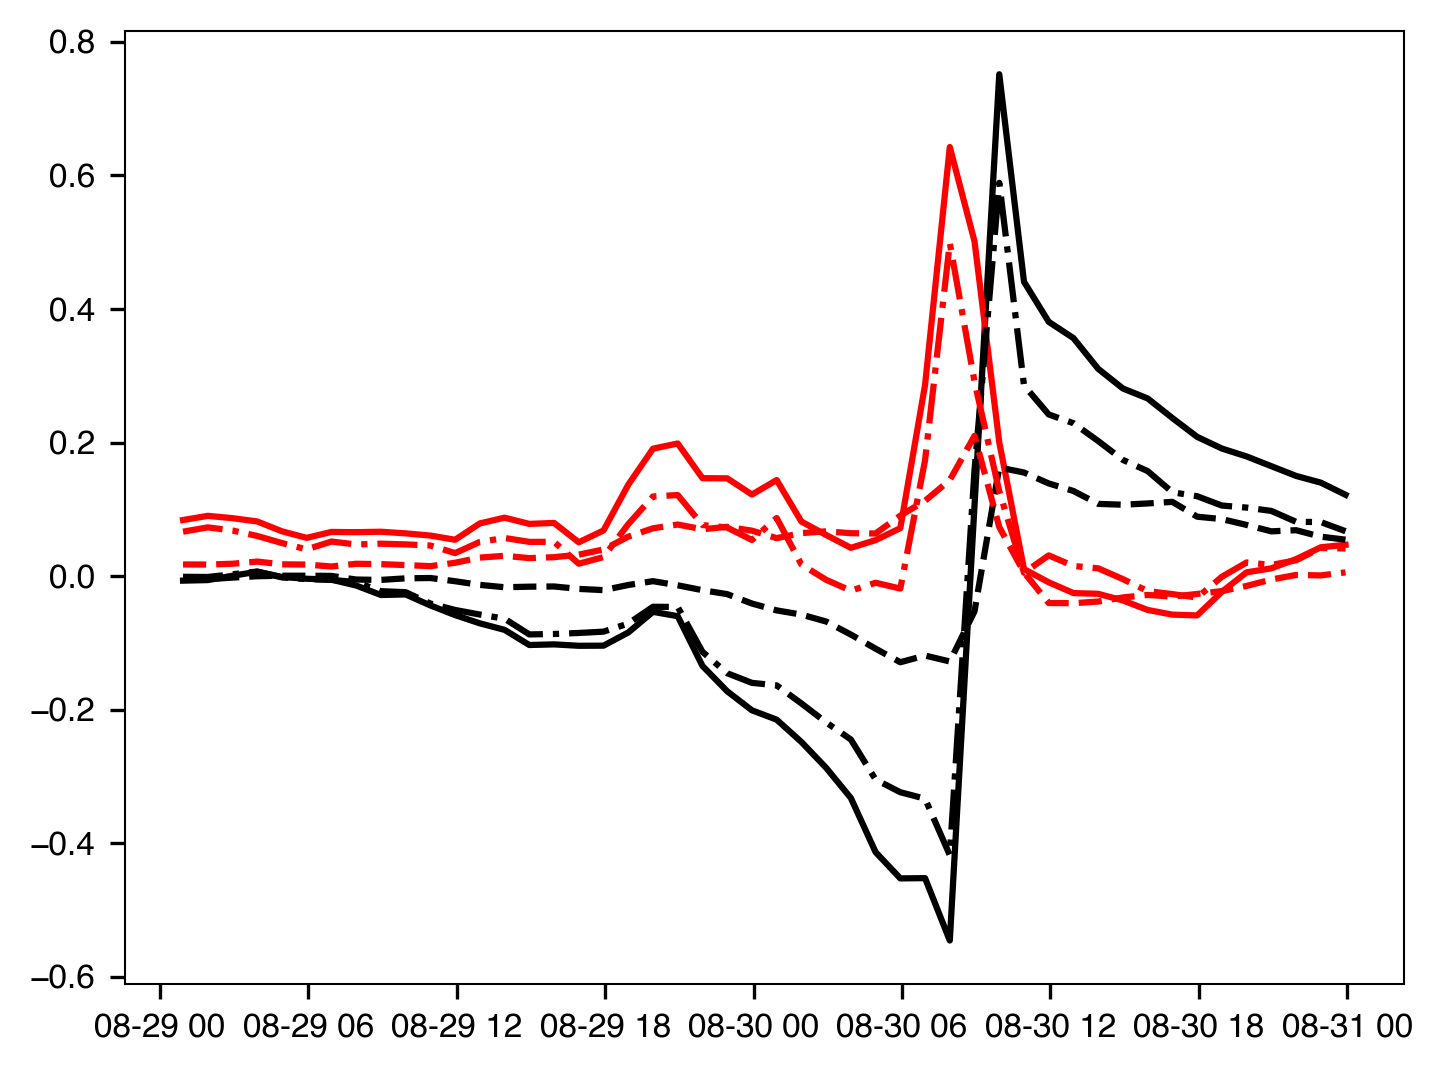

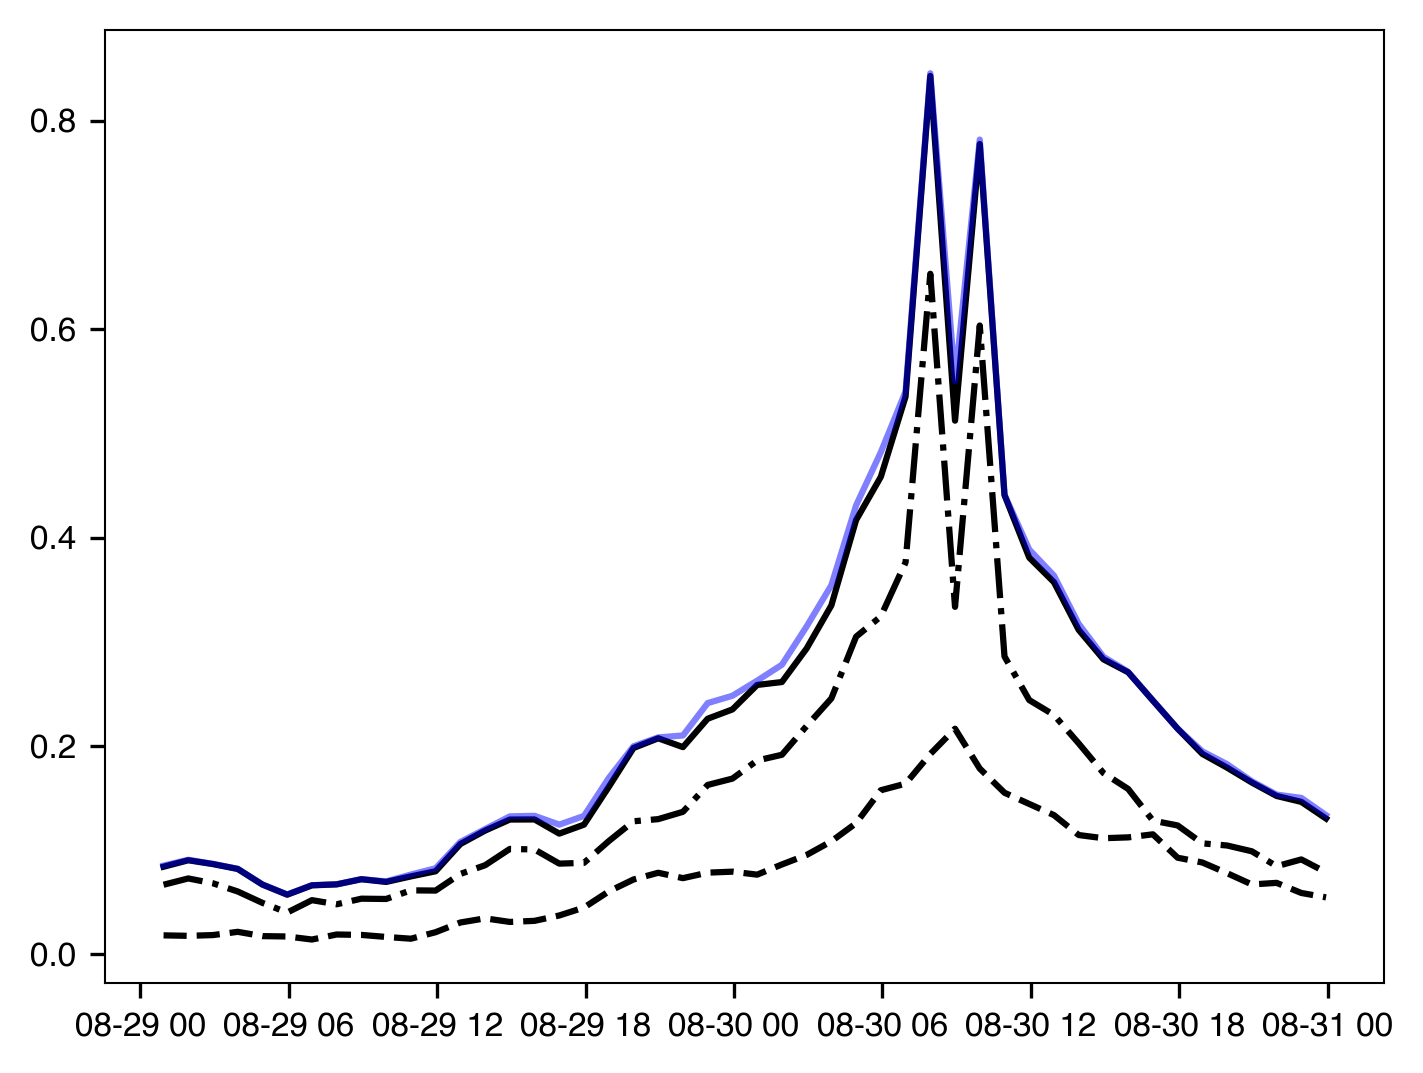

In [43]:
fig, ax = plt.subplots()
ax.plot(
    spotter_df.loc['SPOT-30103D'].index.get_level_values('time'),
    spotter_df.loc['SPOT-30103D']['drift_speed_east_relative_to_surface'],
    linestyle='-',
    color='k',
)
ax.plot(
    spotter_df.loc['SPOT-30103D'].index.get_level_values('time'),
    spotter_df.loc['SPOT-30103D']['drift_speed_north_relative_to_surface'],
    linestyle='-',
    color='r',
)
ax.plot(
    spotter_df.loc['SPOT-30103D'].index.get_level_values('time'),
    spotter_df.loc['SPOT-30103D']['stokes_drift_east'],
    linestyle='--',
    color='k',
)
ax.plot(
    spotter_df.loc['SPOT-30103D'].index.get_level_values('time'),
    spotter_df.loc['SPOT-30103D']['stokes_drift_north'],
    linestyle='--',
    color='r',
)
ax.plot(
    spotter_df.loc['SPOT-30103D'].index.get_level_values('time'),
    spotter_df.loc['SPOT-30103D']['drift_speed_east_wind'],
    linestyle='-.',
    color='k',
)
ax.plot(
    spotter_df.loc['SPOT-30103D'].index.get_level_values('time'),
    spotter_df.loc['SPOT-30103D']['drift_speed_north_wind'],
    linestyle='-.',
    color='r',
)


fig, ax = plt.subplots()
ax.plot(
    spotter_df.loc['SPOT-30103D'].index.get_level_values('time'),
    spotter_df.loc['SPOT-30103D']['drift_speed_wind'],
    color='k',
    linestyle='-.',
)
ax.plot(
    spotter_df.loc['SPOT-30103D'].index.get_level_values('time'),
    spotter_df.loc['SPOT-30103D']['stokes_drift_magnitude'],
    color='k',
    linestyle='--',
)
ax.plot(
    spotter_df.loc['SPOT-30103D'].index.get_level_values('time'),
    spotter_df.loc['SPOT-30103D']['drift_speed_relative_to_surface'],
    color='k',
    linestyle='-',
)
ax.plot(
    spotter_df.loc['SPOT-30103D'].index.get_level_values('time'),
    spotter_df.loc['SPOT-30103D']['stokes_drift_magnitude'] + spotter_df.loc['SPOT-30103D']['drift_speed_wind'],
    color='b',
    linestyle='-',
    alpha=0.5,
)

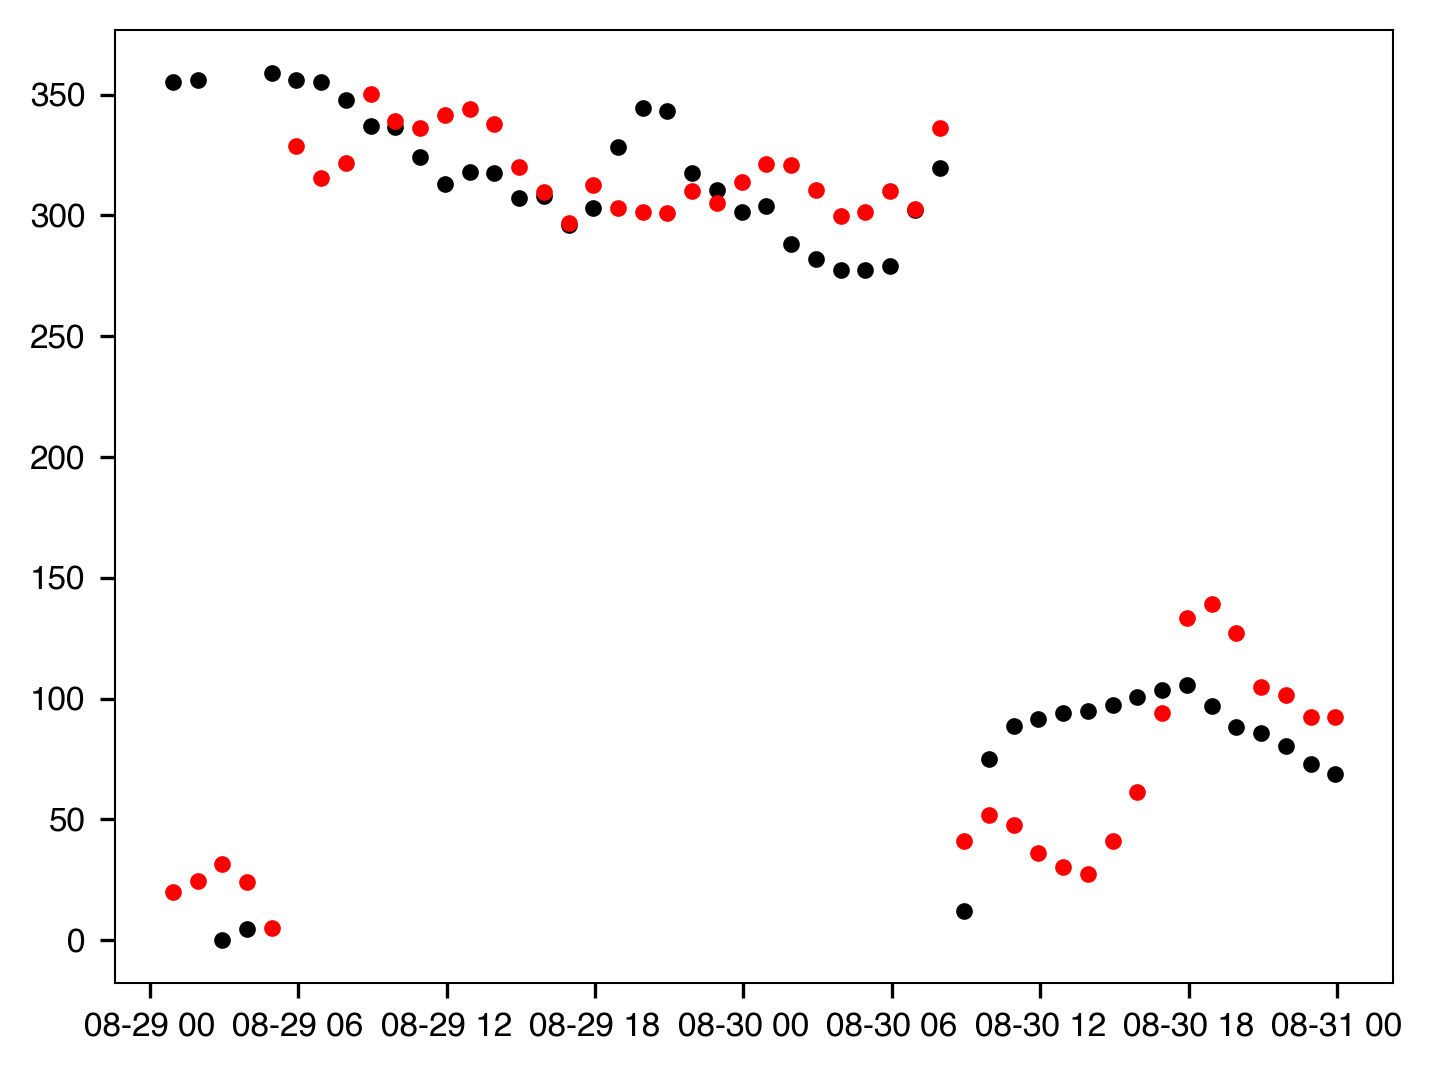

In [68]:
fig, ax = plt.subplots()
ax.scatter(
    spotter_df.loc['SPOT-30103D'].index.get_level_values('time'),
    spotter_df.loc['SPOT-30103D']['drift_direction_relative_to_surface'],
    color='k',
)
ax.scatter(
    spotter_df.loc['SPOT-30103D'].index.get_level_values('time'),
    spotter_df.loc['SPOT-30103D']['drift_direction'],
    color='r',
)

In [69]:
# Compute a smoothed, frequency dependent direction
spotter_df['direction_smoothed'] = spotter_df.buoy.sliding_energy_weighted_direction(window_size=7)

# Doppler adjust the energy densities and frequencies and recalculate mss
new_cols = ['energy_density_intrinsic', 'frequency_intrinsic']
spotter_df[new_cols] = spotter_df.buoy.doppler_adjust(
    frequency_cutoff=1,
    drift_speed_col='drift_speed_relative_to_surface',
    drift_direction_col='drift_direction_relative_to_surface',
    direction_col='direction_smoothed',
    interpolate=True,
)

Repeat for the Ian and Fiona data.

In [70]:
# Drift speed
ian_spotter_coamps_df['drift_speed_wind'] = mean_wind_slip * ian_spotter_coamps_df['wind_speed']
fiona_spotter_coamps_df['drift_speed_wind'] = mean_wind_slip * fiona_spotter_coamps_df['wind_speed']

# Smoothed direction
ian_spotter_coamps_df['direction_smoothed'] = ian_spotter_coamps_df.buoy.sliding_energy_weighted_direction(window_size=7)
fiona_spotter_coamps_df['direction_smoothed'] = fiona_spotter_coamps_df.buoy.sliding_energy_weighted_direction(window_size=7)

# Doppler adjustment
new_cols = ['energy_density_intrinsic', 'frequency_intrinsic']
ian_spotter_coamps_df[new_cols] = ian_spotter_coamps_df.buoy.doppler_adjust(
    frequency_cutoff=1,
    drift_speed_col='drift_speed_wind',
    direction_col='direction_smoothed',
    interpolate=True,
)
fiona_spotter_coamps_df[new_cols] = fiona_spotter_coamps_df.buoy.doppler_adjust(
    frequency_cutoff=1,
    drift_speed_col='drift_speed_wind',
    direction_col='direction_smoothed',
    interpolate=True,
)

/Users/jacob/Dropbox/Projects/NHCI/code/ocean-surface-wave-slopes-and-wind-wave-alignment/src/waves.py:437: RuntimeWarning: invalid value encountered in divide
  return weighted / moment_0
/Users/jacob/Dropbox/Projects/NHCI/code/ocean-surface-wave-slopes-and-wind-wave-alignment/src/waves.py:437: RuntimeWarning: invalid value encountered in divide
  return weighted / moment_0


## Projected drift speed

Calculate the drift speed projected onto the wave direction.  This will be used later to search for a secondary dependence related to surface current gradients, as observed in Iyer et al. (2022).  The mss-weighted wave direction is used, since this is the wave direction at the frequencies with the largest contribution to mss.

In [71]:
def projected_drift_speed(
    drift_speed: float,
    drift_direction_going: float,
    wave_direction_coming: np.ndarray,
) -> np.ndarray:
    """ Return the drift speed projection of onto a wave direction. """
    # Compute drift-wave misalignment.
    wave_direction_going = kinematics.coming_to_going(wave_direction_coming, modulus=360)
    misalignment_deg = kinematics.wave_drift_alignment(wave_direction_going,
                                                 np.array([drift_direction_going]))
    misalignment_rad = np.deg2rad(misalignment_deg).squeeze()

    # Compute the Doppler shift speed projection.
    cos_misalignment = np.cos(misalignment_rad)
    return drift_speed * cos_misalignment

In [88]:
spotter_df['mss_weighted_projected_drift_speed'] = projected_drift_speed(
    drift_speed=spotter_df['drift_speed_adjusted'].values,
    drift_direction_going=spotter_df['drift_direction'].values,
    wave_direction_coming=spotter_df['mss_weighted_direction'].values,
)

microswift_df['mss_weighted_projected_drift_speed'] = projected_drift_speed(
    drift_speed=microswift_df['drift_speed'].values,
    drift_direction_going=microswift_df['drift_direction'].values,
    wave_direction_coming=microswift_df['mss_weighted_direction'].values,
)

/var/folders/5k/tj9m5nbs0rb__4sp5qh876yc0000gn/T/ipykernel_52529/2960420269.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  spotter_df['mss_weighted_projected_drift_speed'] = projected_drift_speed(


## MicroSWIFT motion correction

The microSWIFTs do not need a Doppler shift adjustment, but the energy at the highest frequencies in the tail should be set to the energy derived from the vertical velocity and not the energy derived horizontal velocities which may have motion contamination due to the microSWIFT's pitch natural frequency.  The vertical velocity energy can be recovered using the check factor, which is the ratio of vertical-to-horizontal energy.

In [73]:
def motion_correct_microswifts(energy_density, wave_check_factor):
    n = 3  # number of highest frequencies to correct
    energy_density_corrected = energy_density.copy()
    energy_density_corrected[-n:] = energy_density[-n:] * wave_check_factor[-n:]
    return energy_density_corrected

In [74]:
microswift_df['energy_density_intrinsic'] = microswift_df.apply(
    lambda df: motion_correct_microswifts(
        df['energy_density'],
        df['wave_check_factor'],
    ),
    axis=1,
)
microswift_df['frequency_intrinsic'] = microswift_df['frequency'].copy()

## Recalculate mean square slope

Calculate energy density in the wavenumber domain using frequency spectra in the intrinsic reference frame.  Though wavenumber is technically invariant between frames, we will define a `'wavenumber_intrinsic'` which is calculated from the intrinsic frequency.

In [75]:
# Calculate energy density as a function of wavenumber using intrinsic spectra.
spotter_df[['energy_density_intrinsic_wn', 'wavenumber_intrinsic']] \
    = spotter_df.buoy.wavenumber_energy_density(
        energy_density_col='energy_density_intrinsic',
        frequency_col='frequency_intrinsic',
        var_rtol=0.05,
    )

/Users/jacob/Dropbox/Projects/NHCI/code/ocean-surface-wave-slopes-and-wind-wave-alignment/src/waves.py:493: RuntimeWarning: There are 1 entries with a variance mismatch. Filling mismatched entries with NaN.
  warnings.warn(


Calculate intermediate depth, wave-number based mss using intrinsic wavenumber spectra.  Define the minimum and maximum wavenumbers based on the deep water wavelengths that correspond to 0.05 Hz to 0.5 Hz.

In [76]:
min_wavenumber = 2*np.pi / 624  # 1/m
max_wavenumber = 2*np.pi / 6.2  # 1/m

In [77]:
# Calculate wavenumber-based mss.
spotter_df['mean_square_slope_intrinsic'] \
    = spotter_df.buoy.wavenumber_mean_square_slope(
        energy_density_wn_col='energy_density_intrinsic_wn',
        wavenumber_col='wavenumber_intrinsic',
        min_wavenumber=min_wavenumber,
        max_wavenumber=max_wavenumber,
)
# Replace zeroes with NaNs
# mss_is_zero = spotter_df['mean_square_slope_intrinsic'] == 0
# spotter_df.loc[mss_is_zero, 'mean_square_slope_intrinsic'] = np.nan
spotter_df['mean_square_slope_intrinsic'] \
    = spotter_df['mean_square_slope_intrinsic'].replace(0, np.nan)

Recalculate deep-limit, frequency-based mean square slope:

In [78]:
# Calculate frequency-based mss using intrinsic spectra.
spotter_df['mean_square_slope_intrinsic_deep_limit'] = spotter_df.buoy.mean_square_slope(
    energy_density_col='energy_density_intrinsic',
    frequency_col='frequency_intrinsic',
    min_frequency=0.05,
    max_frequency=0.5,
)
# Replace zeroes with NaNs
mss_is_zero = spotter_df['mean_square_slope_intrinsic_deep_limit'] == 0
spotter_df.loc[mss_is_zero, 'mean_square_slope_intrinsic_deep_limit'] = np.nan

Repeat for microSWIFTs.

In [79]:
# Calculate energy density as a function of wavenumber using intrinsic spectra.
microswift_df[['energy_density_intrinsic_wn', 'wavenumber_intrinsic']] \
    = microswift_df.buoy.wavenumber_energy_density(
        energy_density_col='energy_density_intrinsic',
        frequency_col='frequency_intrinsic',
        var_rtol=0.05,
    )

In [80]:
# Calculate wavenumber-based mss using intrinsic spectra.
microswift_df['mean_square_slope_intrinsic'] \
    = microswift_df.buoy.wavenumber_mean_square_slope(
        energy_density_wn_col='energy_density_intrinsic_wn',
        wavenumber_col='wavenumber_intrinsic',
        min_wavenumber=min_wavenumber,
        max_wavenumber=max_wavenumber,
)
# Replace zeroes with NaNs
mss_is_zero = microswift_df['mean_square_slope_intrinsic'] == 0
microswift_df.loc[mss_is_zero, 'mean_square_slope_intrinsic'] = np.nan

In [81]:
# Calculate frequency-based mss using intrinsic spectra.
microswift_df['mean_square_slope_intrinsic_deep_limit'] = microswift_df.buoy.mean_square_slope(
    energy_density_col='energy_density_intrinsic',
    frequency_col='frequency_intrinsic',
    min_frequency=0.05,
    max_frequency=0.5,
)
# Replace zeroes with NaNs
mss_is_zero = microswift_df['mean_square_slope_intrinsic_deep_limit'] == 0
microswift_df.loc[mss_is_zero, 'mean_square_slope_intrinsic_deep_limit'] = np.nan

Ian and Fiona mean square slopes will be based on intrinsic frequency (these datasets are in deeper water).

In [82]:
ian_spotter_coamps_df['mean_square_slope_intrinsic_deep_limit'] = ian_spotter_coamps_df.buoy.mean_square_slope(
    energy_density_col='energy_density_intrinsic',
    frequency_col='frequency_intrinsic',
    min_frequency=0.05,
    max_frequency=0.5,
)

fiona_spotter_coamps_df['mean_square_slope_intrinsic_deep_limit'] = fiona_spotter_coamps_df.buoy.mean_square_slope(
    energy_density_col='energy_density_intrinsic',
    frequency_col='frequency_intrinsic',
    min_frequency=0.05,
    max_frequency=0.5,
)

# Replace zeroes with NaNs
mss_is_zero = ian_spotter_coamps_df['mean_square_slope_intrinsic_deep_limit'] == 0
ian_spotter_coamps_df.loc[mss_is_zero, 'mean_square_slope_intrinsic_deep_limit'] = np.nan
mss_is_zero = fiona_spotter_coamps_df['mean_square_slope_intrinsic_deep_limit'] == 0
fiona_spotter_coamps_df.loc[mss_is_zero, 'mean_square_slope_intrinsic_deep_limit'] = np.nan


## Comparison of intrinsic and observed reference frames

Plot a comparison of intrinsic (Doppler shift adjusted) and observed scalar energy spectra to a nearby microSWIFT (33 km away).

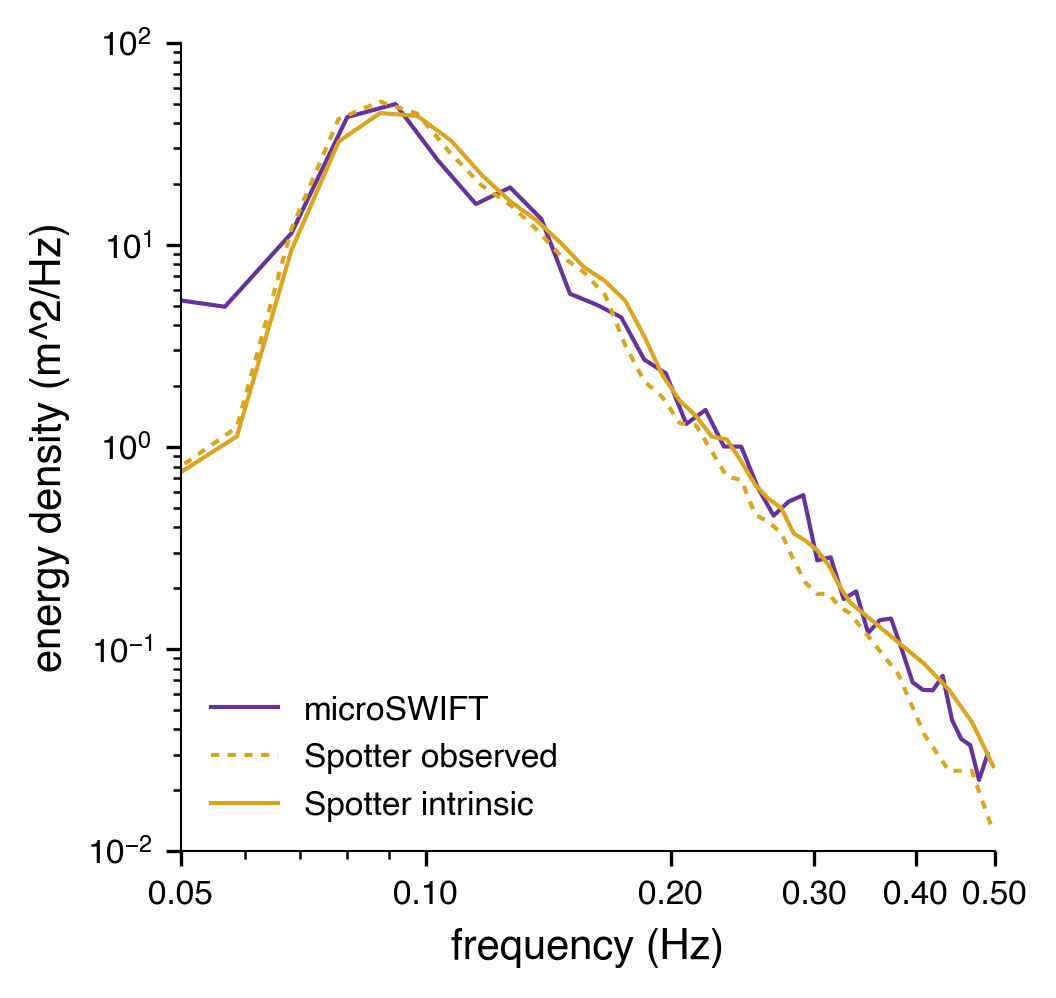

In [83]:
FIGURE_SIZE = (3.5, 3.5)

# Plots are functions so that they can be reused for publication figures.
def plot_doppler_adjusted_spotter_spectrum(
    ax,
    spotter_df,
    microswift_df,
):
    ax.plot(
       microswift_df['frequency'],
       microswift_df['energy_density_intrinsic'],
        label='microSWIFT',
        linewidth=1,
        color=plotting.get_drifter_color('microswift'),
    )
    ax.plot(
        spotter_df['frequency'],
        spotter_df['energy_density'],
        label='Spotter observed',
        linewidth=1,
        linestyle='--',
        dashes = (2, 2),
        color=plotting.get_drifter_color('spotter'),
    )
    ax.plot(
        spotter_df['frequency_intrinsic'],
        spotter_df['energy_density_intrinsic'],
        label='Spotter intrinsic',
        linewidth=1,
        color=plotting.get_drifter_color('spotter'),
    )
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('frequency (Hz)')
    ax.set_ylabel('energy density (m^2/Hz)')
    ax.legend(frameon=False, loc='lower left')
    ax.set_xlim([0.05, 0.5])
    ax.set_xticks([0.05, 0.1, 0.2, 0.3, 0.4, 0.5], minor=False)
    ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    ax.set_ylim([10**(-2), 10**(2)])
    plotting.remove_top_and_right_spines(ax)


# Use nearby Spotter and microSWIFT observations.
start_time = pd.Timestamp('2023-08-30 06:00:00+00:00')
end_time = start_time + pd.Timedelta('1h')

spotter_id= 'SPOT-30101D'
microswift_id = '048'

spotter_subset_df = spotter_df.loc[(spotter_id, slice(start_time, end_time)), :].squeeze()
microswift_subset_df = microswift_df.loc[(microswift_id, slice(start_time, end_time)), :].squeeze()


fig, ax = plt.subplots(figsize=FIGURE_SIZE)
plot_doppler_adjusted_spotter_spectrum(
    ax,
    spotter_subset_df,
    microswift_subset_df,
)

Compare intrinsic and observed mean square slope.  Values are rounded to the third decimal place.

In [84]:
percent_difference_increase = percent_increase(
    spotter_subset_df['mean_square_slope_observed'].round(3),
    spotter_subset_df['mean_square_slope_intrinsic'].round(3),
)

percent_difference_observed = percent_difference(
    microswift_subset_df['mean_square_slope_intrinsic'].round(3),
    spotter_subset_df['mean_square_slope_observed'].round(3),
)

percent_difference_intrinsic = percent_difference(
    microswift_subset_df['mean_square_slope_intrinsic'].round(3),
    spotter_subset_df['mean_square_slope_intrinsic'].round(3),
)

print(f"Spotter observed: {spotter_subset_df['mean_square_slope_observed'].round(3)}")
print(f"Spotter intrinsic: {spotter_subset_df['mean_square_slope_intrinsic'].round(3)}")
print(f"microSWIFT intrinsic: {microswift_subset_df['mean_square_slope_intrinsic'].round(3)}")

print(f'percent increase observed to intrinsic (Spotter): {percent_difference_increase:.0f}%')
print(f'percent difference observed (b/t Spotter and microSWIFT): {percent_difference_observed:.0f}%')
print(f'percent difference intrinsic (b/t Spotter and microSWIFT): {percent_difference_intrinsic:.0f}%')

print(f'wind speed: {spotter_subset_df["wind_speed"]:.0f} m/s')

Spotter observed: 0.016
Spotter intrinsic: 0.021
microSWIFT intrinsic: 0.02
percent increase observed to intrinsic (Spotter): 31%
percent difference observed (b/t Spotter and microSWIFT): 22%
percent difference intrinsic (b/t Spotter and microSWIFT): 5%
wind speed: 35 m/s


After the Doppler adjustment, Spotter mss calculated from the spectra shown here increased by 19\%, from 0.016 (observed) to 0.019 (intrinsic). The spectrum reported by a nearby (33 km away) microSWIFT is shown for comparison ($\mathrm{mss}=0.020$).  At this time instance, the percent difference between the Spotter and microSWIFT slopes reduced from 22\% (observed) to 5\% (intrinsic).  The 10-m wind speed at this observation is 35 $\mathrm{m \: s^{-1}}$ such that the wind-induced drift speed is 0.4 $\mathrm{m \: s^{-1}}$.

Mean square slopes at the highest wind speeds ($> 30 \: \mathrm{m \: s^{-1}}$) can increase by as much as 30\% after adjusting to the intrinsic frame.

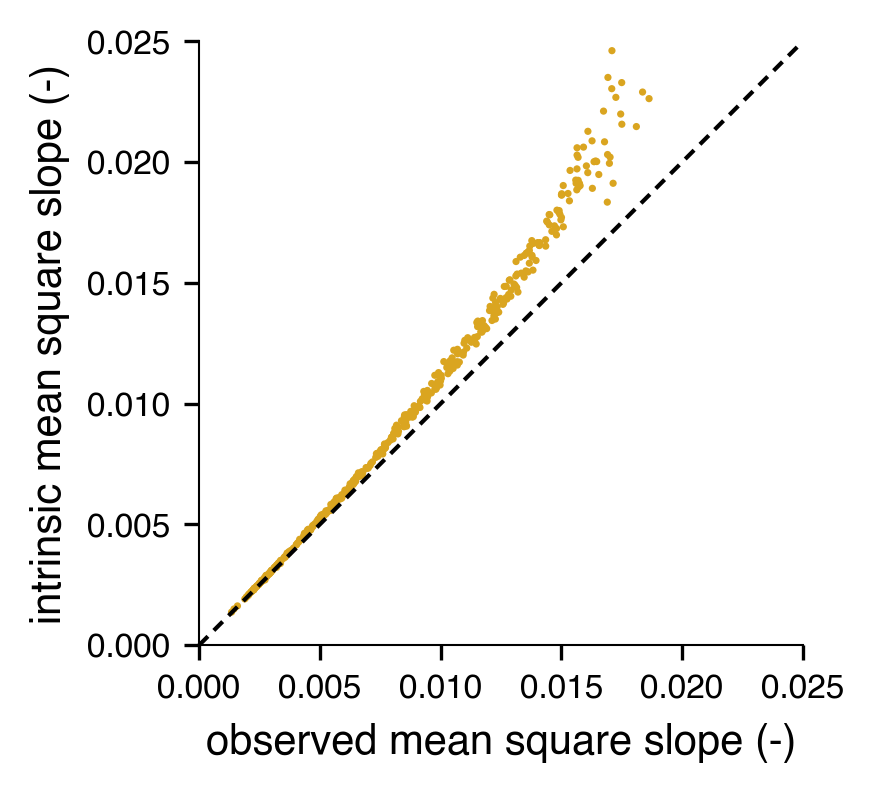

In [85]:
FIGURE_TITLE = 'adjusted_mean_square_slope_versus_wind_speed'
FIGURE_SIZE = (3, 3)


def plot_intrinsic_versus_observed_mean_square_slope(
    ax,
    spotter_df,
):
    ax.scatter(
        spotter_df['mean_square_slope_observed'],
        spotter_df['mean_square_slope_intrinsic'],
        **plotting.spotter_scatter_kwargs,
    )
    limits = [0, 0.025]
    ax.plot(limits, limits, linestyle='--', dashes=(3, 2), linewidth=1, color='k', clip_on=False)
    ax.set_ylabel('intrinsic mean square slope (-)')
    ax.set_xlabel('observed mean square slope (-)')
    ax.set_xlim(limits)
    ax.set_ylim(limits)
    ax.set_aspect('equal')
    plotting.remove_top_and_right_spines(ax)


fig, ax = plt.subplots(figsize=FIGURE_SIZE)
plot_intrinsic_versus_observed_mean_square_slope(ax, spotter_df)
fig.tight_layout()
# fig.savefig(FIGURE_TITLE + '.png')

## Store

Store the updated variables for use in subsequent notebooks.

In [86]:
%%capture
%store microswift_df
%store spotter_df
%store ian_spotter_coamps_df
%store fiona_spotter_coamps_df

## References

Amador, A., Merrifield, S. T., & Terrill, E. J. (2023). Assessment of Atmospheric and Oceanographic Measurements from an Autonomous Surface Vehicle. Journal of Atmospheric and Oceanic Technology, 40(3), 305–326. https://doi.org/10.1175/JTECH-D-22-0060.1

Collins, C. O., Blomquist, B., Persson, O., Lund, B., Rogers, W. E., Thomson, J., Wang, D., Smith, M., Doble, M., Wadhams, P., Kohout, A., Fairall, C., & Graber, H. C. (2017). Doppler Correction of Wave Frequency Spectra Measured by Underway Vessels. Journal of Atmospheric and Oceanic Technology, 34(2), 429–436. https://doi.org/10.1175/JTECH-D-16-0138.1

Colosi, L., Pizzo, N., Grare, L., Statom, N., & Lenain, L. (2023). Observations of Surface Gravity Wave Spectra from Moving Platforms. Journal of Atmospheric and Oceanic Technology, 40(10), 1153–1169. https://doi.org/10.1175/JTECH-D-23-0022.1

Houghton, I., Smit, P., Clark, D., Dunning, C., Fisher, A., Nidzieko, N., Chamberlain, P., & Janssen, T. (2021). Performance statistics of a real-time Pacific Ocean weather sensor network. Journal of Atmospheric and Oceanic Technology. https://doi.org/10.1175/JTECH-D-20-0187.1

Iyer, S., Thomson, J., Thompson, E., & Drushka, K. (2022). Variations in Wave Slope and Momentum Flux From Wave‐Current Interactions in the Tropical Trade Winds. Journal of Geophysical Research: Oceans, 127(3). https://doi.org/10.1029/2021JC018003
